# Caso Práctico: Clasificación de sentimientos

## Conjunto de datos

Este es un conjunto de datos está formado por 25.000 críticas de películas del IMDB (Internet Movie Database), etiquetadas por sentimiento (positivo/negativo). Las reseñas han sido preprocesadas, y cada reseña está codificada como una lista de índices de palabras (números enteros). Para mayor comodidad, las palabras se indexan por frecuencia general en el conjunto de datos, de modo que, por ejemplo, el número entero "3" codifica la tercera palabra más frecuente en los datos. Esto permite realizar operaciones de filtrado rápido como considerar sólo las 10.000 palabras más comunes.

In [73]:
# <-- Machine learning -->
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# <-- Deep learning -->
from keras import datasets
import tensorflow as tf
from keras import models
from keras import layers
from keras.utils import to_categorical
from keras.models import load_model
from keras.datasets import imdb
from keras import optimizers

# <-- data analytics -->
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [74]:
# Vectorizamos las reseñas convirtiendolas en vectores de 10.000 valores 1s y 0s
def vectorize(seqs, dim=10000):
    results = np.zeros((len(seqs), dim))
    for i, seq in enumerate(seqs):
        results[i, seq] = 1.
    return results

## 1. Cargando el conjunto de datos

In [75]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

El argumento _num_words_ indica que únicamente tendremos en cuenta las 10.000 palabras más frecuentes del conjunto de datos. Por lo tanto, el resto de palabras que sean poco frecuentes, serán descartadas y no formarán parte de las reseñas con las que entrenaremos y probaremos el algoritmo.

Tanto _train_data_ como _test_data_ se corresponden con una lista de reseñas. Cada una de las reseñas se corresponde con una lista de números enteros que representan el índice de una palabra. Para conocer que índice tiene cada palabra, podemos llamar al método _get_word_index()_

In [76]:
# Índices de las palabras
word_index = imdb.get_word_index()
word_index

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [77]:
# Primera reseña del conjunto de datos de entrenamiento
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Es importante tener en cuenta que a la hora de visualizar las reseñas debemos aplicar un offset de -3 debido a que el número 0, 1 y 2 están reservados para "padding", "start of sequence" y "unknown" respectivamente.

In [78]:
# Decodificando la reseña utilizando los índices de las palabras
reversed_word_index = {v: k for k, v in word_index.items()}
' '.join([reversed_word_index.get(i - 3, "({})".format(i)) for i in train_data[0]])

"(1) this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert (2) is an amazing actor and now the same being director (2) father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for (2) and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also (2) to the two little boy's that played the (2) of norman and paul they were just brilliant children are often left out of the (2) list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have don

Las variables _train_labels_ y _test_labels_ se corresponden con una lista de valores que puede ser 1, si la reseña es positiva, o 0, si la reseña es negativa

In [79]:
# La reseña anterior se corresponde con una reseña positiva
print(train_labels[0])

1


## 2. Preprocesamiento del conjunto de datos

A pesar de que ya tenemos codificadas las reseñas para que esten representadas por valores numéricos en lugar de por cadenas de texto, existen algunos factores que no permiten que sean conjuntos de datos apropiados para proporcionarle a una red neuronal artifical.

Una de las limitaciones fundamentales es que cada reseña tiene un número diferente de palabras.

In [80]:
# Para que lo anterior funcione se basa en la siguiente propiedad
a = np.zeros(15)
print("Array original:\t\t", a)
a[[0, 3, 5, 7, 9]] = 1.
print("Array modificado:\t", a)

Array original:		 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Array modificado:	 [1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]


Vectorizamos tanto el conjunto de datos de entrenamiento, como el conjunto de datos de pruebas.

In [81]:
# Vectorizamos el conjunto de datos de entrenamiento y el de pruebas
X_train = vectorize(train_data, 10000)
X_test = vectorize(test_data, 10000)

In [82]:
# Cada una de las reseñas se corresponde con un vector formado por 1s y 0s
print("Valores originales:\t", train_data[0][:15])
print("Valores vectorizados:\t", X_train[0][:15])

Valores originales:	 [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4]
Valores vectorizados:	 [0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]


## 3. División del conjunto de datos

In [83]:
X_test, X_val, Y_test, Y_val = train_test_split(X_test, test_labels, test_size=0.5)

In [84]:
Y_train = train_labels

In [85]:
print("Longitud subconjunto entrenamiento: ", len(X_train))
print("Longitud subconjunto validación: ", len(X_val))
print("Longitud subconjunto pruebas: ", len(X_test))

Longitud subconjunto entrenamiento:  25000
Longitud subconjunto validación:  12500
Longitud subconjunto pruebas:  12500


## 4. Construcción de la red neuronal artificial

In [86]:
model = models.Sequential()
model.add(layers.Dense(16, activation='tanh', input_shape=(10000,)))
model.add(layers.Dense(16, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))

/Users/cristianariel/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [87]:
model.compile(
    optimizer=optimizers.SGD(learning_rate=0.001), 
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision']
)

In [88]:
history = model.fit(
    X_train,
    Y_train,
    epochs=40,
    validation_data=(X_val, Y_val))

Epoch 1/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - Precision: 0.5536 - accuracy: 0.5526 - loss: 0.6853 - val_Precision: 0.7091 - val_accuracy: 0.6967 - val_loss: 0.6460
Epoch 2/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Precision: 0.7258 - accuracy: 0.7236 - loss: 0.6323 - val_Precision: 0.7720 - val_accuracy: 0.7626 - val_loss: 0.5991
Epoch 3/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Precision: 0.7800 - accuracy: 0.7825 - loss: 0.5813 - val_Precision: 0.7794 - val_accuracy: 0.7905 - val_loss: 0.5557
Epoch 4/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Precision: 0.7950 - accuracy: 0.8039 - loss: 0.5386 - val_Precision: 0.7758 - val_accuracy: 0.8032 - val_loss: 0.5166
Epoch 5/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Precision: 0.7988 - accuracy: 0.8136 - loss: 0.5000 - val_Precision: 0.7891 - val_accuracy: 0.8141 - val_loss: 0.4814
Epoch 6/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Precision: 0.8107 - accuracy: 0.8256 - loss: 0.4643 - val_Precision: 0.8097 - val_accu

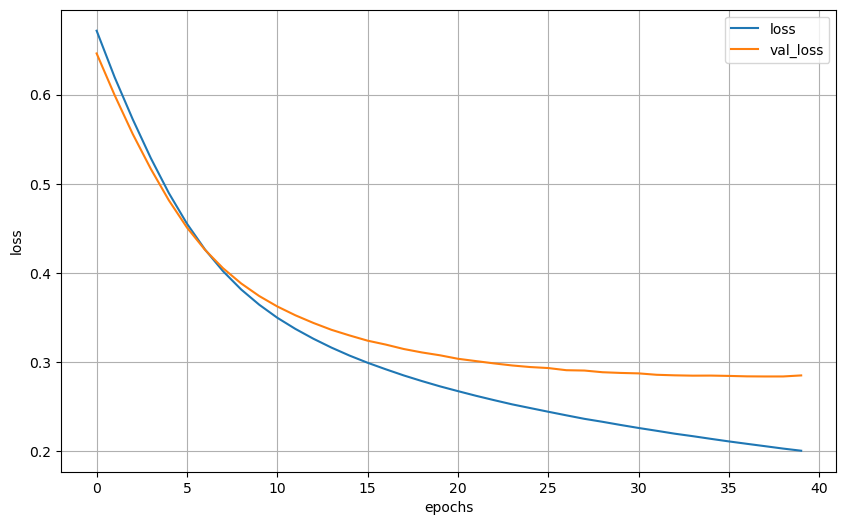

In [89]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

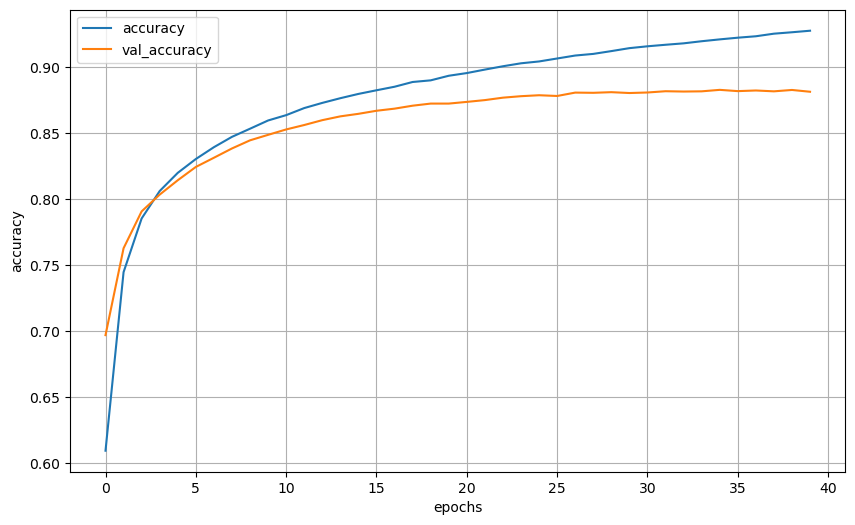

In [90]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

### 4.1 Evaluación con el subconjunto de pruebas

In [91]:
test_loss, test_acc, test_prec = model.evaluate(X_test, Y_test)

391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - Precision: 0.8985 - accuracy: 0.8840 - loss: 0.2825


In [92]:
print('test_acc:', test_acc)
print('test_prec:', test_prec)

test_acc: 0.8831200003623962
test_prec: 0.8938139081001282


## 5. Otros preprocesamientos del conjunto de datos

### Cargando el conjunto de datos

In [93]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [94]:
# Índices de las palabras
word_index = imdb.get_word_index()

In [95]:
# Decodificando una de las reseñas utilizando los índices de las palabras de manera más eficientes
reversed_word_index = {v: k for k, v in word_index.items()}

" ".join([reversed_word_index.get(i - 3, "({})".format(i)) for i in train_data[0]])

"(1) this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert (2) is an amazing actor and now the same being director (2) father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for (2) and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also (2) to the two little boy's that played the (2) of norman and paul they were just brilliant children are often left out of the (2) list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have don

In [96]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

### Preparación del conjunto de datos

In [97]:
X_train_prep = []
X_test_prep = []

In [98]:
# Preprocesando el conjunto de datos de entrenamiento
for review in train_data:
    X_train_prep.append(
        " ".join([reversed_word_index.get(i - 3, "") for i in review]))

In [99]:
X_train_prep[0]

" this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert  is an amazing actor and now the same being director  father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for  and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also  to the two little boy's that played the  of norman and paul they were just brilliant children are often left out of the  list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the

In [100]:
# Preprocesando el conjunto de datos pruebas
for review in test_data:
    X_test_prep.append(
        " ".join([reversed_word_index.get(i - 3, "") for i in review]))

In [116]:
X_test_prep

[" lovely   as the widow are kidnapped and held for  by the  played by one dashing sean connery the incident comes during  as theodore  runs for election to the  in his own right needing a good example to show off the muscular foreign policy of the united states brian keith as  issues a stunning  to the  of  alive or dead br br but in this adaptation of that incident the famous  is the only true thing about this story the in question was in reality one  who was a greek immigrant and  playboy in fact gave up his american  years ago and was back as a greek national never mind that though his  was  enough at the time br br the damsel in distress makes better screen material though so it's a widow woman and her two kids that are in  way here of course as presented here the incident is also used by some of our european powers to get their  into  the  get far beyond one demand for  br br the wind and the lion is hardly history but it is an enjoyable film and sean connery is always fun to wat

In [101]:
X_test_prep[0]

" please give this one a miss br br   and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite  so all you madison fans give this a miss"

In [102]:
Y_train = train_labels
Y_test = test_labels

### División del conjunto de datos

Lo ideal es aplicar la división del conjunto de datos antes de realizar ningún preprocesamiento para que no se infiera ningún tipo de tendencia como consecuencia de la transformación.

In [103]:
X_test_prep, X_val_prep, Y_test, Y_val = train_test_split(X_test_prep, Y_test, test_size=0.5)

In [104]:
print("Longitud subconjunto entrenamiento: ", len(X_train_prep))
print("Longitud subconjunto validación: ", len(X_val_prep))
print("Longitud subconjunto pruebas: ", len(X_test_prep))

Longitud subconjunto entrenamiento:  25000
Longitud subconjunto validación:  12500
Longitud subconjunto pruebas:  12500


### Vectorización del conjunto de datos

In [105]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train_prep)

In [106]:
X_train = X_train.toarray()

In [107]:
pd.DataFrame(X_train, columns=[vectorizer.get_feature_names_out()])

,00,000,10,100,1000,101,11,12,13,13th,...,zhang,zizek,zodiac,zombi,zombie,zombies,zone,zoom,zorro,zu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
X_test = vectorizer.transform(X_test_prep)
X_test = X_test.toarray()

X_val = vectorizer.transform(X_val_prep)
X_val = X_val.toarray()

### Entrenamiento de la red neuronal artificial

In [122]:
model = models.Sequential()

activation_function = 'relu'
model.add(layers.Dense(16, activation=activation_function, input_shape=(X_train.shape[1],)))
model.add(layers.Dense(16, activation=activation_function))
model.add(layers.Dense(1, activation='sigmoid'))

/Users/cristianariel/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [110]:
model.compile(
    # modify sgd learning rate param for obtain most f1 score
    optimizer=optimizers.SGD(learning_rate=0.0005), 
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision']
)

In [111]:
history = model.fit(
    X_train,
    Y_train,
    epochs=10,
    validation_data=(X_val, Y_val))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - Precision: 0.5670 - accuracy: 0.5560 - loss: 0.6856 - val_Precision: 0.6081 - val_accuracy: 0.6049 - val_loss: 0.6699
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - Precision: 0.6451 - accuracy: 0.6230 - loss: 0.6593 - val_Precision: 0.6766 - val_accuracy: 0.6570 - val_loss: 0.6393
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - Precision: 0.6864 - accuracy: 0.6703 - loss: 0.6296 - val_Precision: 0.6971 - val_accuracy: 0.6936 - val_loss: 0.6111
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - Precision: 0.7087 - accuracy: 0.7016 - loss: 0.6008 - val_Precision: 0.7243 - val_accuracy: 0.7222 - val_loss: 0.5856
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Precision: 0.7478 - accuracy: 0.7366 - loss: 0.5737 - val_Precision: 0.7370 - val_accuracy: 0.7449 - val_loss: 0.5631
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Precision: 0.7565 - accuracy: 0.7543 - loss: 0.5520 - val_Precision: 0.7693 - val_accu

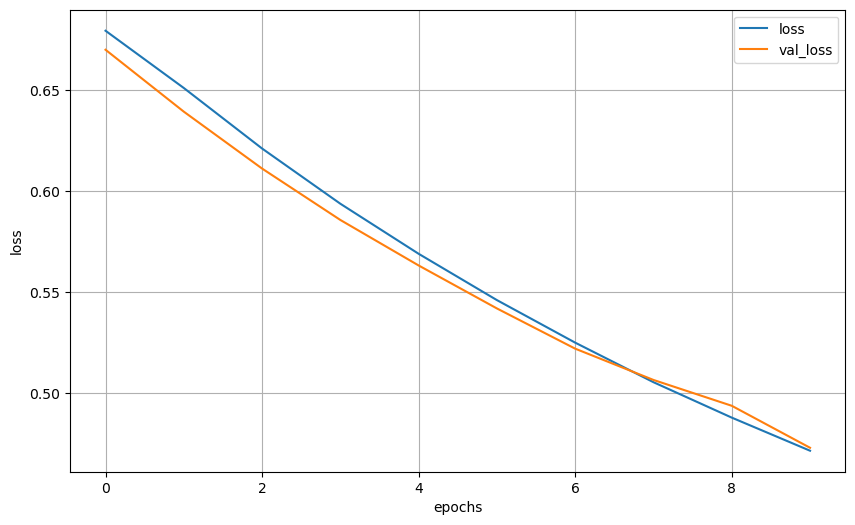

In [112]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

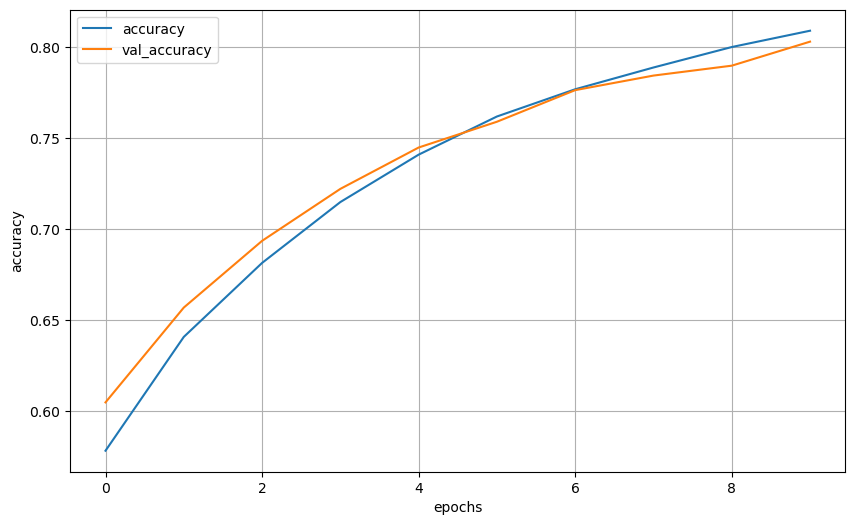

In [113]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

### Evaluación con el subconjunto de pruebas

In [114]:
test_loss, test_acc, test_prec = model.evaluate(X_test, Y_test)

391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Precision: 0.8034 - accuracy: 0.8023 - loss: 0.4709


In [115]:
print('test_acc:', test_acc)
print('test_prec:', test_prec)

test_acc: 0.8005599975585938
test_prec: 0.7993316650390625
